In [5]:
import matplotlib.pyplot as plt # data plotting
import numpy as np # linear algebra
from dataclasses import *
import scipy.optimize as optimize
import sys
sys.path.insert(0, '/Users/niyi/Documents/GitHub/Optimal-Control/Tools')
from EnforceTyping import enforce_method_typing, EnforceClassTyping
sys.path.insert(1, '/Users/niyi/Documents/GitHub/Optimal-Control/Code/Systems')
from ParticlesandFields import Field, ClassicalParticle
sys.path.insert(2, '/Users/niyi/Documents/GitHub/Optimal-Control/Code/Optimal Control Methods/Planning Methods')
from DirectCollocation import  DirectCollocation

In [6]:
@dataclass
class CartPole(EnforceClassTyping, DirectCollocation):
    cart_mass: float # (kg)
    pendulum_mass: float # (kg)
    pendulum_length: float # (m)
    gravitational_acceleration: float # (m/s^2)
    u_min: float # minimum control force (N)
    u_max : float # maximum control force (N)
    track_min: float
    track_max: float
    
    def __post_init__(self):
      self.time_interval= self.final_time/ (self.n_time_steps-1)
      self.optimal_trajectory= self.initial_guess

    def objective(self, flattened_trajectory: np.ndarray) -> float:
      u = flattened_trajectory[4*self.n_time_steps:]
      return np.sum(u**2) * self.time_interval
    
    def state_dynamics(self, state: np.ndarray, time: float, control: np.ndarray):
        x1, x2, x3, x4 = state
        dx1 = x2
        dx2 = (self.pendulum_length*self.pendulum_mass*np.sin(x2)* x4**2+ control+ self.pendulum_mass*self.gravitational_acceleration*np.cos(x2)*np.sin(x2)) / self.cart_mass+ self.pendulum_mass*(1-np.cos(x2)**2)
        dx3 = x4
        dx4 = (self.pendulum_length*self.pendulum_mass*np.cos(x2)*np.sin(x2)* x4**2+ control*np.cos(x2)+ (self.pendulum_mass+self.cart_mass)*self.gravitational_acceleration*np.sin(x2)) / self.pendulum_length*(self.cart_mass+ self.pendulum_mass*(1-np.cos(x2)**2))
        
        return np.array([dx1, dx2, dx3, dx4])
    
    def dynamics_constraint(self, flattened_trajectory: np.ndarray):

      position_x, position_y, velocity_x, velocity_y, control = flattened_trajectory.reshape(self.initial_state.size+ np.prod(self.control_dims), self.n_time_steps)
      state_vectors= np.vstack((position_x, position_y, velocity_x, velocity_y)).transpose()
      control_vectors= control.transpose()
      ceq = []

      for k in range(self.n_time_steps-1):
        time= k* self.time_interval
        state_derivative = self.state_dynamics(state=state_vectors[k], time= time, control=control_vectors[k])
        next_state_derivative = self.state_dynamics(state=state_vectors[k+1], time= time, control=control_vectors[k+1])
        actual_state_change= (state_vectors[k+1] - state_vectors[k])
        expected_state_change= (self.time_interval * (state_derivative + next_state_derivative))/2
        ceq.append(actual_state_change - expected_state_change)
      return np.array(ceq).transpose().flatten()
    
    def boundary_constraints(self, flattened_trajectory: np.ndarray):
      position_x, position_y, velocity_x, velocity_y, _= flattened_trajectory.reshape(self.initial_state.size+ np.prod(self.control_dims), self.n_time_steps)
      final_state_vector= np.vstack((position_x, position_y, velocity_x, velocity_y)).transpose()[-1]
      initial_state_vetor= np.vstack((position_x, position_y, velocity_x, velocity_y)).transpose()[0]
      trajectory_boundary= np.concatenate((initial_state_vetor, final_state_vector), axis=None)
      boundary_constraint= np.concatenate((self.initial_state, self.final_state), axis=None)
      return trajectory_boundary-boundary_constraint
    
    def solve(self):
        solution = optimize.minimize(self.objective, 
                                     self.initial_guess, 
                                     method='SLSQP', 
                                     constraints=({'type': 'eq', 'fun': self.dynamics_constraint}, 
                                                  {'type': 'eq', 'fun': self.boundary_constraints},
                                                  {'type': 'ineq', 'fun': lambda z: self.u_max - z[4*self.n_time_steps:]},  # u <= u_max
                                                  {'type': 'ineq', 'fun': lambda z: z[4*self.n_time_steps:] - self.u_min},
                                                  {'type': 'ineq', 'fun': lambda z: self.track_max - z[:self.n_time_steps]},
                                                  {'type': 'ineq', 'fun': lambda z: z[:self.n_time_steps] - self.track_min},))   # u >= u_min
        self.optimal_trajectory= solution.x
    
    def plot_trajectory(self, flattened_trajectory: np.ndarray= None):
      if flattened_trajectory is None:
        flattened_trajectory= self.optimal_trajectory
      t = np.linspace(0, self.final_time, self.n_time_steps)
      position_x, position_y, velocity_x, velocity_y, control = flattened_trajectory.reshape(self.initial_state.size+ np.prod(self.control_dims), self.n_time_steps)
      state_vectors= np.vstack((position_x, position_y, velocity_x, velocity_y)).transpose()
      control_vectors= control.transpose()

      plt.figure(figsize=(12, 10))

      plt.subplot(3, 2, 1)
      plt.plot(t, state_vectors[:, 0])
      plt.title('Cart Position')
      plt.xlabel('Time (s)')
      plt.ylabel('Position (m)')

      plt.subplot(3, 2, 3)
      plt.plot(t, state_vectors[:, 1])
      plt.title('Pendulum Angle')
      plt.xlabel('Time (s)')
      plt.ylabel('Angle (rad)')

      plt.subplot(3, 2, 2)
      plt.plot(t, state_vectors[:, 2])
      plt.title('Cart Velocity')
      plt.xlabel('Time (s)')
      plt.ylabel('Velocity (m/s)')

      plt.subplot(3, 2, 4)
      plt.plot(t, state_vectors[:, 3])
      plt.title('Pendulum Angular Velocity')
      plt.xlabel('Time (s)')
      plt.ylabel('Angular Velocity (rad/s)')

      plt.subplot(3, 2, 5)
      plt.plot(t, control_vectors)
      plt.title('Control Input')
      plt.xlabel('Time (s)')
      plt.ylabel('Force (N)')
      plt.axhline(y=self.u_max, color='r', linestyle='--', label='Max Force')
      plt.axhline(y=self.u_min, color='r', linestyle='--', label='Min Force')
      plt.legend()

      plt.tight_layout()
      plt.show()


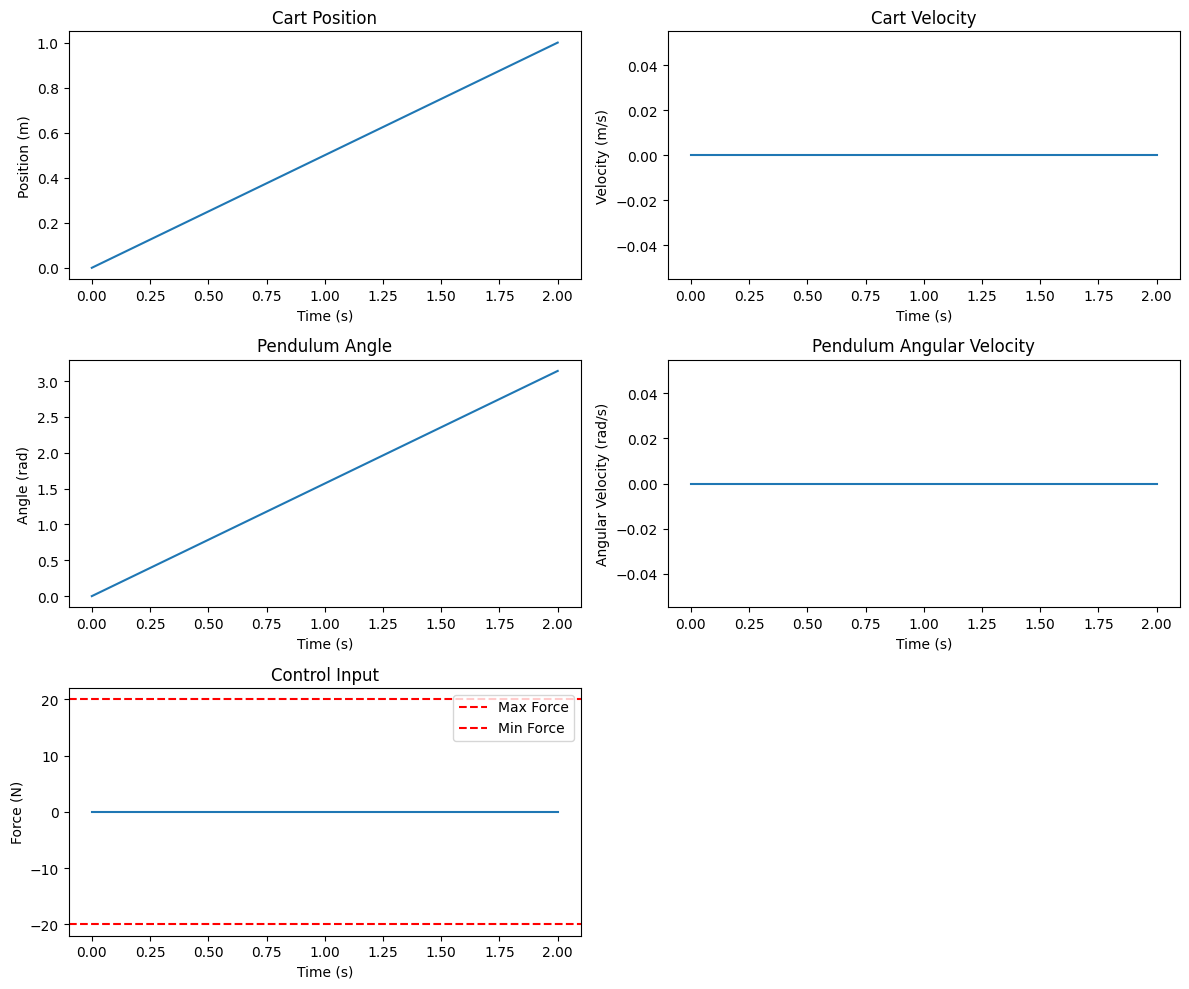

0.0

In [7]:
cart_mass = 1.0  # (kg)
pendulum_mass = 0.3  # (kg)
pendulum_length = 0.5    # (m)
gravitational_acceleration = 9.81   # (m/s^2)

# Time discretization
n_time_steps = 100    # number of time steps
final_time = 2.0  # final time (s)
dt = final_time / (n_time_steps - 1)

# Control force limits
u_min = -20.0  # minimum control force (N)
u_max = 20.0   # maximum control force (N)

n_time_steps= 100
final_time= 2.0
final_state= np.array([1.0, np.pi, 0.0, 0.0])#[x, y, v_x, v_y]
initial_state= np.array([0.0, 0.0, 0.0, 0.0])#[x, y, v_x, v_y]
control_dims= (1,)

initial_guess= np.zeros(n_time_steps*(initial_state.size+ np.prod(control_dims)))
initial_guess[:n_time_steps] = np.linspace(initial_state[0], final_state[0], n_time_steps)  # xPosition Initial Guess
initial_guess[n_time_steps:2*n_time_steps] = np.linspace(initial_state[1], final_state[1], n_time_steps)  # yPosition Initial Guess
initial_guess[2*n_time_steps:3*n_time_steps] = np.linspace(initial_state[2], final_state[2], n_time_steps)  # xVelocity Initial Guess
initial_guess[3*n_time_steps:4*n_time_steps] = np.linspace(initial_state[3], final_state[3], n_time_steps)  # yVelocity Initial Guess

swing_up_cart_pole= CartPole(n_time_steps, 
                                   final_time, 
                                  initial_state,
                                  final_state, 
                                  control_dims, 
                                  initial_guess, 
                                  cart_mass,
                                  pendulum_mass,
                                  pendulum_length,
                                  gravitational_acceleration,
                                  u_min, 
                                  u_max,
                                  0.0,
                                  2.0)
swing_up_cart_pole.plot_trajectory(initial_guess)
swing_up_cart_pole.objective(initial_guess)

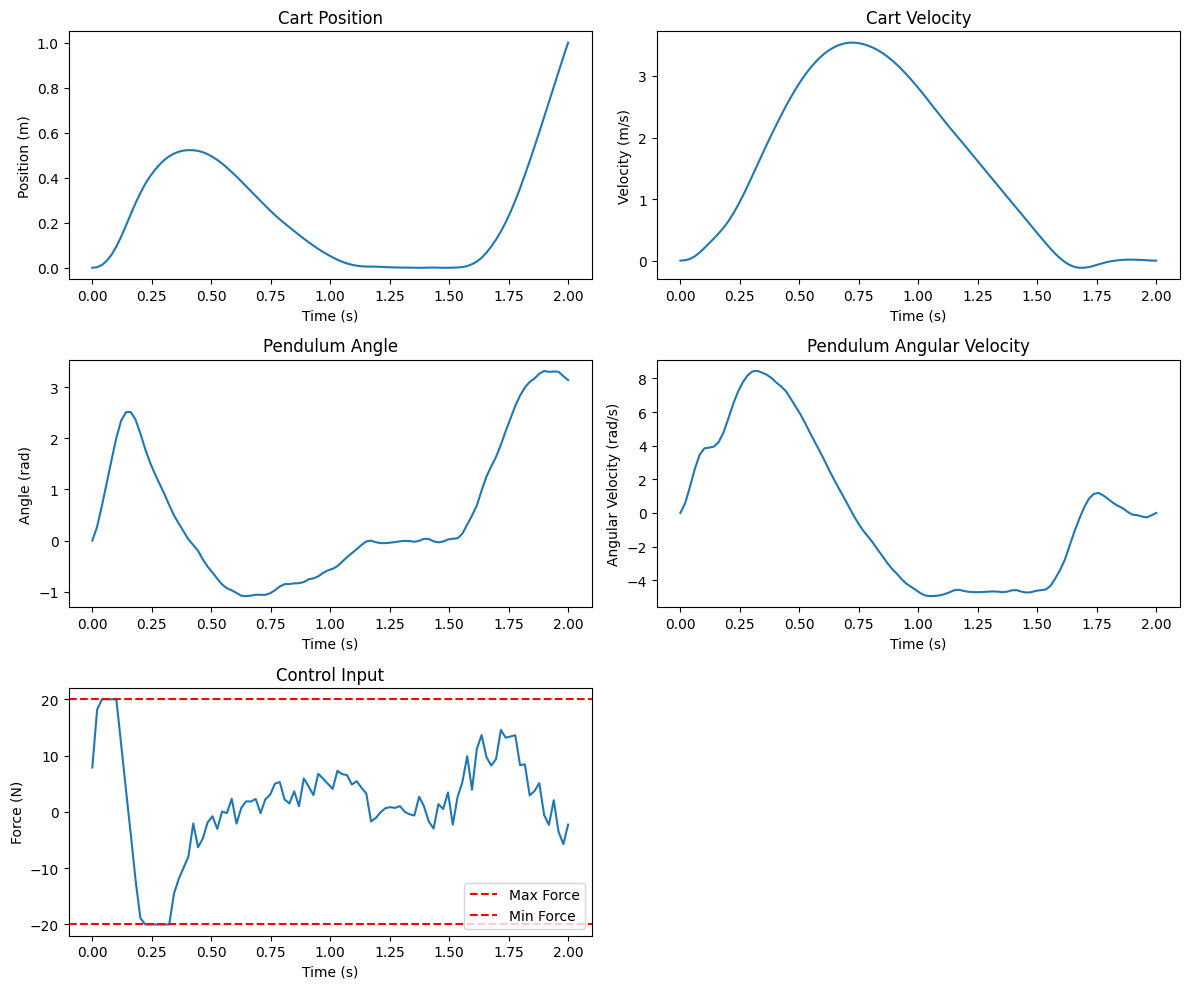

160.29618628042456

In [8]:
swing_up_cart_pole.solve()
swing_up_cart_pole.plot_trajectory()
swing_up_cart_pole.objective(swing_up_cart_pole.optimal_trajectory)